In [1]:
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
from networkx.algorithms import bipartite
import numpy as np
from collections import deque
import random
import pickle
from time import time
import copy
import matplotlib.pyplot as plt
from math import isclose
import cvxpy as cp

In [2]:
input_file = './synth.pickle'
pipageSetting = "randomized"

env = gp.Env(empty=True)
# env.setParam("Threads", 16)
# env.setParam("OutputFlag",0) # suppress gurobi console output
env.start()
timeLimit = 2000

times = dict() # dictionary to keep time for different stages
start = time()
# Read graph
with open(input_file, 'rb') as file:
    projects = pickle.load(file)
    node_capacities = pickle.load(file)
    task_capacities = pickle.load(file)
    numOfProjects = len(projects)
    c = pickle.load(file)
    w = pickle.load(file)
    edges = pickle.load(file)

G = nx.Graph()
G.add_edges_from(edges)
nodes = list(G.nodes)
n = len(nodes)


# print(f'projects = {projects}')
print(f'number of nodes: {n}')
print(f'number of (conflict) edges: {len(edges)}')
print(f'number of projects: {numOfProjects}')
times["read_input"] = time() - start
# G_c = nx.complement(G) # friends graph
# nx.draw(G_c, pos=nx.spring_layout(G_c))

Set parameter GURO_PAR_SPECIAL
Set parameter TokenServer to value "sccsvc"
number of nodes: 1000
number of (conflict) edges: 450454
number of projects: 10


In [3]:
# helper function
def copy_solution(X):
    x = dict()
    for u in nodes:
        for p in projects:
            x[(u, p)] = X[(u, p)].X
    return x

eps = 0.001

# Define objective function
def f(x):
    res = 0
    # project preference term
    for u in nodes:
        for p in projects:
            if (u, p) in c and (u, p) in x:
                res += c[(u, p)] * x[(u, p)]
    res *= lambda_
    
    # conflict term
    for e in edges:
        u, v = e
        inner_sum = 0
        for p in projects:
            if (u, p) in x and (v, p) in x:
                inner_sum += x[(u, p)] * x[(v, p)]
        res += (1 - inner_sum)
    return res

# Pipage rounding
def construct_graph(x):
    H = nx.Graph()
    H.add_nodes_from(nodes, bipartite=0)
    H.add_nodes_from(projects, bipartite=1)
    edges = [(u, p) for u in nodes for p in projects if (u, p) in x and not x[(u, p)] < eps and not x[(u, p)] > 1 - eps]
    H.add_edges_from(edges)
    return H

def find_cycle(H):
    try:
        cycle = nx.find_cycle(H)
    except Exception:
        cycle = []
    return cycle

def find_path(graph):
    def dfs_with_backtracking(vertex, path):
        nonlocal max_path
        path.append(vertex)

        for neighbor in graph[vertex]:
            if neighbor not in path:
                dfs_with_backtracking(neighbor, path)

        if len(path) > len(max_path):
            max_path = path.copy()

        path.pop()

    max_path = []
    for start_vertex in graph.nodes:
        dfs_with_backtracking(start_vertex, [])
        if max_path:
            return list(zip(max_path, max_path[1:]))
    
    print("No path found...")
    return max_path

def format_path(R):
    R_new = deque()
    for e in R:
        u, p = e if e[0] in nodes else tuple(reversed(e)) # (student, project) edge
        R_new.append((u, p))
    return list(R_new)

# def calc_eps(x, R):
#     # Divide R into M1 and M2 matchings
#     M1 = R[::2]
#     M2 = R[1::2]
    
#     # Calculate eps1, eps2
#     eps1 = min(min([x[e] for e in M1]), min([1 - x[e] for e in M2]))
#     eps2 = min(min([1 - x[e] for e in M1]), min([x[e] for e in M2]))
    
#     return eps1, eps2, M1, M2

def remove_dec_error(x):            
    #only keep the keys corresponding to value 1
    x_new = dict()
    for e in x:
        if x[e] >  1 - eps:
            x_new[e] = 1
    return x_new

# def step(x, eps, M1, M2):
#     x_new = x.copy()
#     for e in M1:
#         x_new[e] += eps
#     for e in M2:
#         x_new[e] -= eps
#     return x_new


# def rand_round(x, eps1, eps2, M1, M2):
#     rand = random.uniform(0, 1)
#     if rand < eps1 / (eps1 + eps2):
# #         x_new = step(x, -eps1, M1, M2)
#         eps = -eps1
#         for e in M1:
#             x[e] += eps
#         for e in M2:
#             x[e] -= eps
#     else:
# #         x_new = step(x, eps2, M1, M2)
#         eps = eps2
#         for e in M1:
#             x[e] += eps
#         for e in M2:
#             x[e] -= eps
#     return x
    
# def clean_edges(x, H):
#     integral_edges = [e for e in H.edges if np.isclose(x[e], 0) or np.isclose(x[e], 1)]
#     H.remove_edges_from(integral_edges)
#     return H

def rand_pipage_help(x, R):
    R = format_path(R)
#     eps1, eps2, M1, M2 = calc_eps(x, R)
    # Divide R into M1 and M2 matchings
    M1 = R[::2]
    M2 = R[1::2]

    # Calculate eps1, eps2
    eps1 = min(min([x[e] for e in M1]), min([1 - x[e] for e in M2]))
    eps2 = min(min([1 - x[e] for e in M1]), min([x[e] for e in M2]))
    
#     x_new = rand_round(x, eps1, eps2, M1, M2)
    rand = random.uniform(0, 1)
    if rand < eps1 / (eps1 + eps2):
#         x_new = step(x, -eps1, M1, M2)
        eps = -eps1
        for e in M1:
            x[e] += eps
        for e in M2:
            x[e] -= eps
    else:
#         x_new = step(x, eps2, M1, M2)
        eps = eps2
        for e in M1:
            x[e] += eps
        for e in M2:
            x[e] -= eps
    return x

def pipage(x, setting="deterministic"):
    H = construct_graph(x)
    print(f'# of edges of H = {len(H.edges())}')
    i = 0
    while True:
        i += 1
        if i%100 == 0:
            print(f'iteration = {i}')
        R = find_cycle(H)
        R = R if R else find_path(H)
        if R and len(R) > 1:
            x = rand_pipage_help(x, R) # randomized
#             clean_edges(x, H)
            integral_edges = [e for e in H.edges if x[e] < eps or x[e] > 1-eps]
            H.remove_edges_from(integral_edges)
        else:
            return remove_dec_error(x)
        
    print("Error: Pipage rounding failed ...")

In [4]:
def rounding34():
    print(f'Running 3/4 approximation algorithm ...')

    start = time()
    
    # Create a new model
    m = gp.Model("linear", env=env)
    m.Params.timeLimit = timeLimit
    
    print('Creating variables ...')
    # Create variables
    X = dict()
    for u in nodes:
        for p in projects:
            X[(u, p)] = m.addVar(vtype=GRB.CONTINUOUS, name=f"X({u},{p})")

    # Auxiliary variables
    Z = dict()
    S = dict()
    for e in edges:
        u = e[0]
        v = e[1]
        for t in projects:
            Z[(u, v, t)] = m.addVar(vtype=GRB.CONTINUOUS, name=f"Z({u}, {v}, {t})")
            S[(u, v, t)] = m.addVar(vtype=GRB.CONTINUOUS, name=f"S({u}, {v}, {t})")
            m.addConstr(S[(u, v, t)] == X[(u, t)] + X[(v, t)])
            m.addConstr(Z[(u, v, t)] == gp.min_(S[(u, v, t)], constant = 1))
            
    print('Adding constraints ...')   
    # Add constraints
    # Each student assigned to exactly one project
    for u in nodes:
        expr = gp.LinExpr(numOfProjects*[1], [X[(u, t)] for t in projects])
        m.addConstr(expr == 1)

    # Project max capacity constraints
    for p in projects:
        expr = gp.LinExpr(n*[1], [X[(u, p)] for u in nodes])
        m.addConstr(expr <= task_capacities[p])
        
    # Relaxed objective L(x)
    print('Setting the objective ...')
    L = gp.LinExpr()

    # Linear (project preference) term
    for u in nodes:
        for p in projects:
            if (u, p) in c:
                L += c[(u, p)] * X[(u, p)]
    L *= lambda_

    # Max-cut term
    for e in edges:
        u = e[0]; v = e[1]
        for p in projects:
            L += w[(u, v)] * Z[(u, v, p)]      
    L -= sum(w.values())

    m.setObjective(L, GRB.MAXIMIZE)    
    times["relax_model34"] = time() - start

    start = time()
    # Optimize model
    print('Optimizing ...')
    m.optimize()

    # Convert solution to dictionary format
    x_frac34 = copy_solution(X)
    times["optimize_relaxation34"] = time() - start

    # round solution
    print('Rounding solution ...')
    start = time()
    x_round34 = pipage(x_frac34, pipageSetting)
    times["rounding34"] = time() - start
    
    return x_round34

In [ ]:
lambda_mul = 10
lambda_ = lambda_mul * sum(w.values()) / n

x_round34 = rounding34()

Running 3/4 approximation algorithm ...
Set parameter TimeLimit to value 2000
Creating variables ...
Adding constraints ...
Setting the objective ...
Optimizing ...
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) Gold 6242 CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 32 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 4505550 rows, 9019080 columns and 13533620 nonzeros
Model fingerprint: 0x29224cf8
Model has 4504540 general constraints
Variable types: 9019080 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 5e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  GenCon const rng [1e+00, 1e+00]
Presolve removed 0 rows and 0 columns (presolve time = 6s) ...
Presolve removed 0 rows and 0 columns (presolve time = 10s) ...
Presolve removed 0 rows and 0 columns (presolve time = 15s) ...
Presolve removed 80

In [ ]:
val = f(x_round34)
val

In [ ]:
def quadratic():
    start = time()
    
    # Create a new model
    m = gp.Model("quadratic", env=env)
    m.Params.timeLimit = timeLimit
    print('Creating variables ...')
    # Create variables
    X = dict()
    for u in nodes:
        for p in projects:
            X[(u, p)] = m.addVar(vtype=GRB.BINARY, name=f"X({u},{p})")
    
    print('Setting up the objective ...')
    # Linear (project preference) term
    F1 = gp.LinExpr()
    for u in nodes:
        for p in projects:
            if (u, p) in c:
                F1 += c[(u, p)] * X[(u, p)]
    F1 *= lambda_

    # max-cut term
    F3 = dict()
    F2 = gp.QuadExpr()
    for e in edges:
        u = e[0]; v = e[1]
        F3[e] = gp.QuadExpr()
        for p in projects:
            F3[e] -=  X[(u, p)] * X[(v, p)]
        F3[e] += 1
        F3[e] *= w[(u, v)]
    for e in edges:
        F2 += F3[e]

    F = gp.QuadExpr()
    F = F1 + F2
    m.setObjective(F, GRB.MAXIMIZE)

    # Add constraints
    print('Adding constraints ...')
    # Each student assigned to exactly one project
    for u in nodes:
        expr = gp.LinExpr(numOfProjects*[1], [X[(u, t)] for t in projects])
        m.addConstr(expr == 1)

    # Project max capacity constraints
    for p in projects:
        expr = gp.LinExpr(n*[1], [X[(u, p)] for u in nodes])
        m.addConstr(expr <= task_capacities[p])

    times["construct_model"] = time() - start

    start = time()
    # Optimize model
    print('Optimizing ...')
    m.optimize()
    # Convert solution to dictionary format
    print("Copying solution ...")
    x_opt = copy_solution(X)
    times["optimize_quad"] = time() - start

    return x_opt

In [8]:
x_opt = quadratic()
val_opt = f(x_opt)

Adding constraints ...
Optimizing ...
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) Gold 6242 CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 32 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 1010 rows, 10000 columns and 20000 nonzeros
Model fingerprint: 0xc86c41d6
Model has 4504540 quadratic objective terms
Variable types: 0 continuous, 10000 integer (10000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+03, 5e+03]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 1225451.2800
Presolve removed 0 rows and 0 columns (presolve time = 79s) ...
Presolve time: 78.81s
Presolved: 1010 rows, 10000 columns, 20000 nonzeros
Presolved model has 4514540 quadratic objective terms
Variable types: 0 continuous, 10000 integer (10000 binary)
Found heuristic solution: objective 1

In [9]:
val_opt

4954494.0

## Sparsify

In [10]:
start = time()
new_edges = [e for e in edges if random.uniform(0, 1) < 0.01]
times['sparsify'] = time() - start

In [11]:
def sparse():
    print(f'Running 3/4 approximation algorithm ...')

    start = time()
    
    # Create a new model
    m = gp.Model("linear", env=env)
    m.Params.timeLimit = timeLimit
    
    print('Creating variables ...')
    # Create variables
    X = dict()
    for u in nodes:
        for p in projects:
            X[(u, p)] = m.addVar(vtype=GRB.CONTINUOUS, name=f"X({u},{p})")

    # Auxiliary variables
    Z = dict()
    S = dict()
    for e in new_edges:
        u = e[0]
        v = e[1]
        for t in projects:
            Z[(u, v, t)] = m.addVar(vtype=GRB.CONTINUOUS, name=f"Z({u}, {v}, {t})")
            S[(u, v, t)] = m.addVar(vtype=GRB.CONTINUOUS, name=f"S({u}, {v}, {t})")
            m.addConstr(S[(u, v, t)] == X[(u, t)] + X[(v, t)])
            m.addConstr(Z[(u, v, t)] == gp.min_(S[(u, v, t)], constant = 1))
            
    print('Adding constraints ...')   
    # Add constraints
    # Each student assigned to exactly one project
    for u in nodes:
        expr = gp.LinExpr(numOfProjects*[1], [X[(u, t)] for t in projects])
        m.addConstr(expr == 1)

    # Project max capacity constraints
    for p in projects:
        expr = gp.LinExpr(n*[1], [X[(u, p)] for u in nodes])
        m.addConstr(expr <= task_capacities[p])
        
    # Relaxed objective L(x)
    print('Setting the objective ...')
    L = gp.LinExpr()

    # Linear (project preference) term
    for u in nodes:
        for p in projects:
            if (u, p) in c:
                L += c[(u, p)] * X[(u, p)]
    L *= lambda_

    # Max-cut term
    for e in new_edges:
        u = e[0]; v = e[1]
        for p in projects:
            L += w[(u, v)] * Z[(u, v, p)]      
    L -= sum(w.values())

    m.setObjective(L, GRB.MAXIMIZE)    
    times["sparse_model"] = time() - start

    start = time()
    # Optimize model
    print('Optimizing ...')
    m.optimize()

    # Convert solution to dictionary format
    x_frac34 = copy_solution(X)
    times["optimize_sparse"] = time() - start

    # round solution
    print('Rounding solution ...')
    start = time()
    x_round34 = pipage(x_frac34, pipageSetting)
    times["round_sparse"] = time() - start
    
    return x_round34

In [12]:
x_sparse = sparse()
val_sparse = f(x_sparse)

Running 3/4 approximation algorithm ...
Set parameter TimeLimit to value 2000
Creating variables ...
Adding constraints ...
Setting the objective ...
Optimizing ...
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) Gold 6242 CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 32 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 45260 rows, 98500 columns and 152750 nonzeros
Model fingerprint: 0x781699b7
Model has 44250 general constraints
Variable types: 98500 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 5e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  GenCon const rng [1e+00, 1e+00]
Presolve removed 0 rows and 44250 columns
Presolve time: 0.36s
Presolved: 45260 rows, 54250 columns, 152750 nonzeros
Variable types: 54250 continuous, 0 integer (0 binary)
Deterministic concurrent LP optimizer: primal an

## CVXPY Concave relaxation

In [13]:
def concave():
    print(f'Creating model for 3/4 approximation algorithm ...')
    start = time()

    print(f'Creating variables X[(u, p)] ...')
    X = dict()
    for u in nodes:
        for p in projects:
            X[(u, p)] = cp.Variable()

    # Add constraints
    print(f'Adding constraints ...')
    constr = list()

    # Each variable between 0 and 1
    for u in nodes:
        for p in projects:
            constr.append(X[(u, p)] >= 0)
            constr.append(X[(u, p)] <= 1)

    # Each student assigned to exactly one project
    for u in nodes:
        constr.append(sum([X[(u, p)] for p in projects]) == 1)

    # Project capacity constraints
    for p in projects:
        constr.append(sum([X[(u, p)] for u in nodes]) <= task_capacities[p])

    print(f'Creating the objective ...')
    # Linear (project preference) term
    L1 = sum(c[(u, p)] * X[(u, p)] for u in nodes for p in projects if (u, p) in c)

    # max-cut (conflicts) term
    L2 = 0
    for e in new_edges:
        u, v = e
        L3 = sum([cp.minimum(1, X[(u, p)] + X[(v, p)]) for p in projects])
        L2 += w[e] * L3

    obj = lambda_ * L1 + L2
    print(f'Done creating 3/4 pipage model.')

    randpipage_model = cp.Problem(cp.Maximize(obj), constr)
    randpipage_model.solve(verbose=True)

    if randpipage_model.status == cp.OPTIMAL:
        optimal_solution = randpipage_model.value
        x_frac34 = {key: var.value for key, var in X.items()}
    else:
        print("Optimization problem is infeasible or failed to converge.")

    x_concave = pipage(x_frac34, "randomized")
    times['concave'] = time() - start
    return x_concave

x_concave = concave()


Creating model for 3/4 approximation algorithm ...
Creating variables X[(u, p)] ...
Adding constraints ...
Creating the objective ...
Done creating 3/4 pipage model.


/usr3/graduate/nikolaou/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Oct 10 12:54:15 PM: Your problem has 10000 variables, 21010 constraints, and 0 parameters.
(CVXPY) Oct 10 12:54:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 10 12:54:17 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 10 12:54:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 10 12:54:19 PM: Compiling problem (target solver=ECOS).
(CVXPY) Oct 10 12:54:19 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr 

In [14]:
val_concave = f(x_concave)

In [15]:
val_compact = 4949954.0
val_random = 1287374.0
approx_ratio34 = val / val_opt
approx_ratio34_compact = val_compact / val_opt
approx_ratio34_sparse = val_sparse / val_opt
approx_ratio34_concave = val_concave / val_opt
approx_ratio_random = val_random / val_opt

In [16]:
print(f'approximation ratio of RPipage = {approx_ratio34}')
print(f'approximation ratio of RPipage compact = {approx_ratio34_compact}')
print(f'approximation ratio of RPipage sparse = {approx_ratio34_sparse}')
print(f'approximation ratio of RPipage concave = {approx_ratio34_concave}')
print(f'approximation ratio of Random = {approx_ratio_random}')

approximation ratio of RPipage = 1.0
approximation ratio of RPipage compact = 0.9990836602082876
approximation ratio of RPipage sparse = 0.996374604550939
approximation ratio of RPipage concave = 0.9879249303763411
approximation ratio of Random = 0.25983965264666786


In [17]:
times

{'read_input': 0.5572772026062012,
 'relax_model34': 149.15010404586792,
 'optimize_relaxation34': 183.45011615753174,
 'rounding34': 0.009106159210205078,
 'construct_model': 42.63662600517273,
 'optimize_quad': 82.34009027481079,
 'sparsify': 0.10115814208984375,
 'sparse_model': 1.3755080699920654,
 'optimize_sparse': 0.9447243213653564,
 'round_sparse': 0.00856161117553711,
 'concave': 753.4979069232941}

In [34]:
def barPlot(specDict):
    plt.figure(figsize=specDict['plotSize'])
#     plt.rc('xtick', labelsize=30) # fontsize of the tick labels
    plt.rc('ytick', labelsize=30) # fontsize of the tick labels
    plt.rc('legend', fontsize=26)
    plt.ylim([0, 1.2])
    barWidth = 0.15

    my_cmap = plt.get_cmap("viridis")

    #Specify X-axis
    X_axis = np.array([1])
    plt.bar(X_axis - 0.3, specDict['linear'], barWidth, label='Linear', color=my_cmap(0.2), hatch='*')
    plt.bar(X_axis - 0.1, specDict['sparse'], barWidth, label='Sparsify-Linear', color=my_cmap(0.75), hatch='+')
    plt.bar(X_axis + 0.1, specDict['concave'], barWidth, label='Sparsify-Concave', color=my_cmap(0.9), hatch='x')
    plt.bar(X_axis + 0.3, specDict['compact'], barWidth, label='Compact-Linear', color=my_cmap(0.4), hatch='-')
    plt.bar(X_axis + 0.5, specDict['random'], barWidth, label='Random', color=my_cmap(0.6), hatch='//')


#     plt.xticks(X_axis, specDict['datasetNames'])
    plt.xlabel(specDict['xlab'], fontsize=specDict['axisFontSize'])
    plt.ylabel(specDict['ylab'], fontsize=specDict['axisFontSize']) 
    plt.legend(loc='best', bbox_to_anchor=(1, 1))
    plt.xticks([], [])

    plt.tight_layout()
    plt.savefig(specDict['saveFileName'], pad_inches=1)
    plt.show()

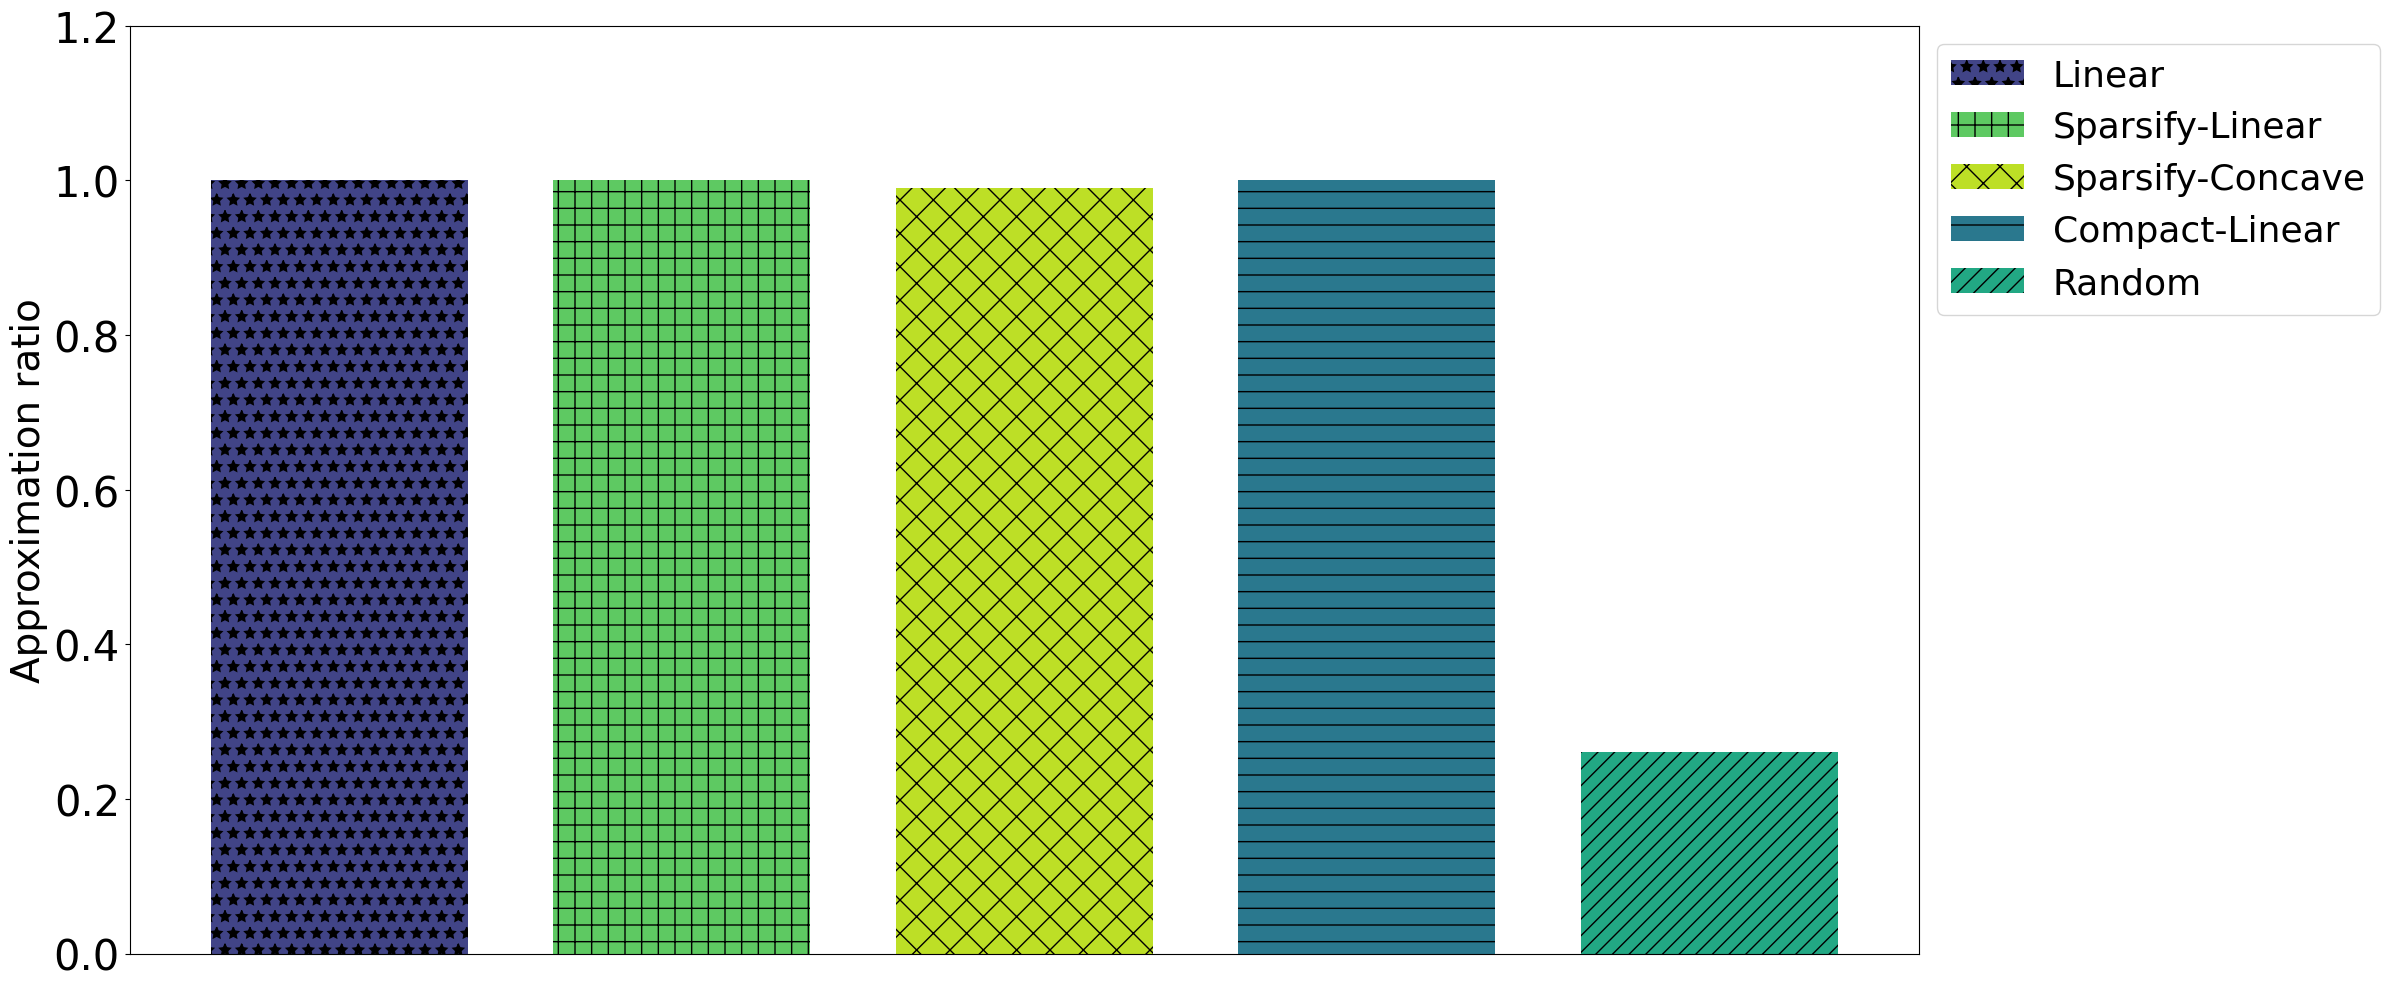

In [35]:
#Specify dictionary for plotting for all Datasets
specDict = {
    'plotSize': (24, 10), 
    'linear': [1], 
    'sparse': [1],
    'concave': [0.99], 
    'compact': [1],
    'random': [0.26],
    'xlab': '', 
    'ylab': 'Approximation ratio' ,
    'plotTitle': '', 
    'axisFontSize': 28, 
    'titleFontSize': 14,
    'saveFileName': './heuristics_comp_ratio.pdf'
}
barPlot(specDict)
